# Mountain cart

This is the notebook for the implement the mountain cart problem. 
It is divided into:
1. Random Agent
2. DQN approach
3. DQN with auxiliary function
4. DQN with RND

In [28]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **1.** Random Agent

In [25]:
from RandomAgent import RandomAgent

env = gym.make('MountainCar-v0')#, render_mode = "human")
agent = RandomAgent(env)
num_episodes = 100

rewards = []
durations=[]
for episode in tqdm(range(num_episodes)):
    t0 = time()
    seed = np.random.randint(0, 100000)
    state = env.reset(seed=seed)
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        agent.observe(state, action, next_state, reward)
        agent.update()
        total_reward += reward
        state = next_state
        done = terminated or truncated
    t1 = time()
    durations.append(t1-t0)
    rewards.append(total_reward)

100%|██████████| 100/100 [00:01<00:00, 51.16it/s]


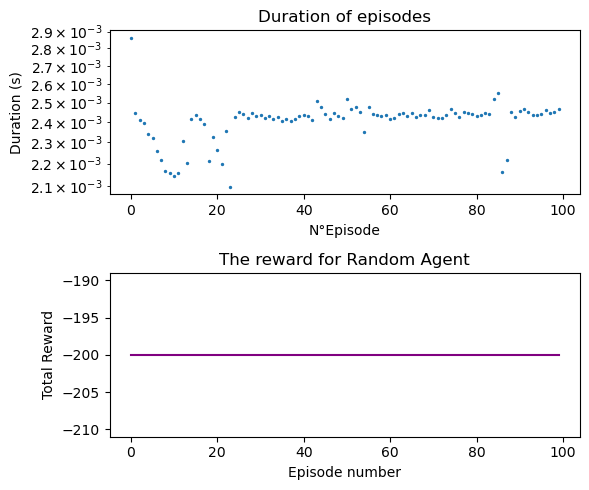

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))

# Scatter plot
ax1.scatter(range(num_episodes), durations, s=2)
ax1.set_yscale('log')
ax1.set_xlabel('N°Episode')
ax1.set_ylabel('Duration (s)')
ax1.set_title('Duration of episodes')

# Line plot
ax2.plot(rewards, color="purple")
ax2.set_title("The reward for Random Agent")
ax2.set_ylabel("Total Reward")
ax2.set_xlabel("Episode number")

plt.tight_layout()
plt.savefig("plots/RandomAgent.png")
plt.show()



# **2.** DQN Agent

100%|██████████| 1000/1000 [02:14<00:00,  7.45it/s]


Directory created:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes/
Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes/


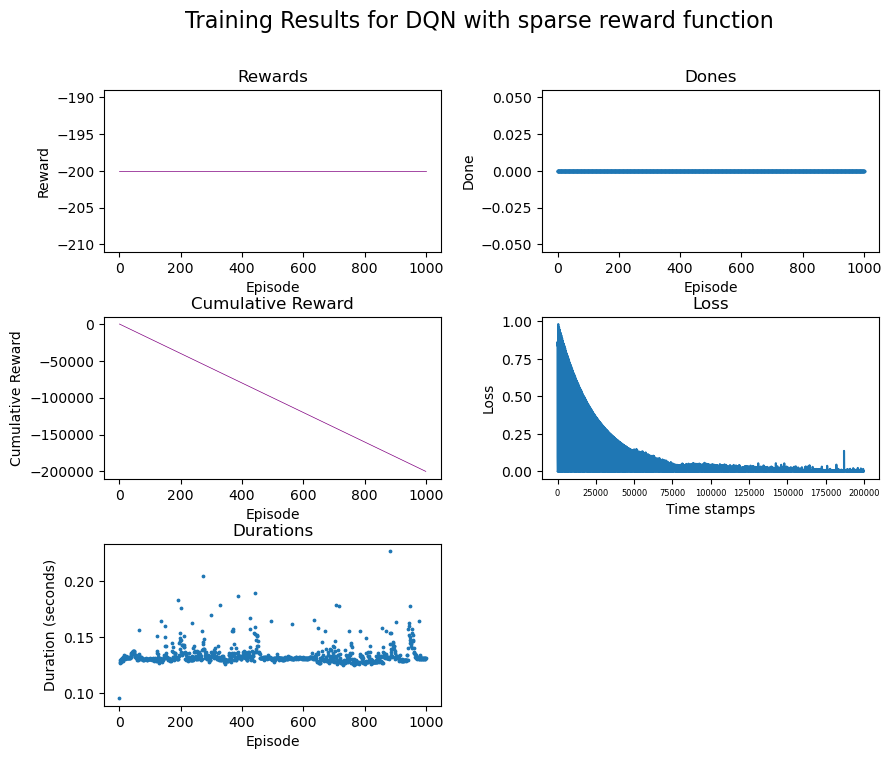

In [36]:
from DQN import DQNAgent, DQNnetwork

num_episodes = 1000
reward_function = "-1"

env = gym.make('MountainCar-v0') #, render_mode = "human"
state_size, action_size = env.observation_space.shape[0], env.action_space.n
agent = DQNAgent(env, state_size, action_size)
agent.train(env, agent, num_episodes,reward_function=reward_function)
agent.save_agent(f"DQN_{num_episodes}_episodes")
agent.sparse_plots()

# **2.1** Modified Reward function of the DQN environment

In [31]:
import numpy as np

def calculate_reward(position, done, step_penalty=10, C=100, D=50):
    goal_position = 0.5   # position of the goal
    min_position = -1.2   # leftmost position
    
    # Normalize the position to be between 0 and 1, where 1 is the goal
    norm_position = (position - min_position) / (goal_position - min_position)

    # Calculate the position-based reward component (proximity to goal)
    position_reward = -C * (1 - norm_position)  # Less negative as it approaches the goal
    
    # Calculate the height-based reward component
    height = np.cos(np.pi * position - np.pi/1.5 + 0.3)
    height_reward = -D * (1 - height)  # Less negative as the cart climbs higher
    
    # Total reward combines position reward, height reward, and a time penalty
    total_reward = position_reward + height_reward
    if not done:
        total_reward -= step_penalty

    return total_reward


In [30]:
import gymnasium as gym
import math
import numpy as np
from typing import Optional

# modify the environment class by inheriting the gymnasium environment class of the mountain cart, and changing the step() function such that the reward is always 1
class MountainCarReward1(gym.Env):
    def __init__(self, C=100, D=50, step_penalty = 10, aux_factor = 1, render_mode: Optional[str] = None):
        self.render_mode = render_mode
        self.env = gym.make('MountainCar-v0', render_mode=render_mode)
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.reward_range = self.env.reward_range
        self.number_steps = 0
        self.C = C
        self.D = D
        self.step_penalty = step_penalty
        self.aux_factor = aux_factor

    def step(self, action: int, reward_function="-1"):
        assert self.action_space.contains(action), f"{action!r} ({type(action)}) invalid"
        state, reward, done, truncated, _ = self.env.step(action)
        self.number_steps += 1
        
        if reward_function == "euclidean":
            aux_reward = 100 if done else np.sqrt(np.abs(state[0] - (-0.5))**2)
        elif reward_function == "complex": 
            aux_reward = calculate_reward(state[0], done, step_penalty=self.step_penalty, C=self.C, D=self.D)
        else:
            aux_reward = 0

        if self.number_steps == 200:
            truncated = True

        final_reward = reward + aux_reward * self.aux_factor
        self.reward = reward
        self.aux_reward = aux_reward
        self.final_reward = final_reward

        return np.array(state, dtype=np.float32), final_reward, done, truncated, {}
    
    def get_decomposed_rewards(self):
        return self.reward, self.aux_reward, self.final_reward

    def reset(self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
        ):
        self.number_steps = 0
        return self.env.reset(seed=seed, options=options)

    def render(self, render_mode='human'):
        return self.env.render(render_mode=render_mode)

    def close(self):
        return self.env.close()

In this case we have a 100 times bigger auxiliary reward function. This is done to make the agent learn faster.<br>
We will try to change these parameters

* + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + 
Training DQN for 3000 episodes with reward function: complex and target update frequency: 100
 



100%|██████████| 3000/3000 [04:23<00:00, 11.37it/s]


Directory created:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_complex_targetfrequency_100/
Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_complex_targetfrequency_100/


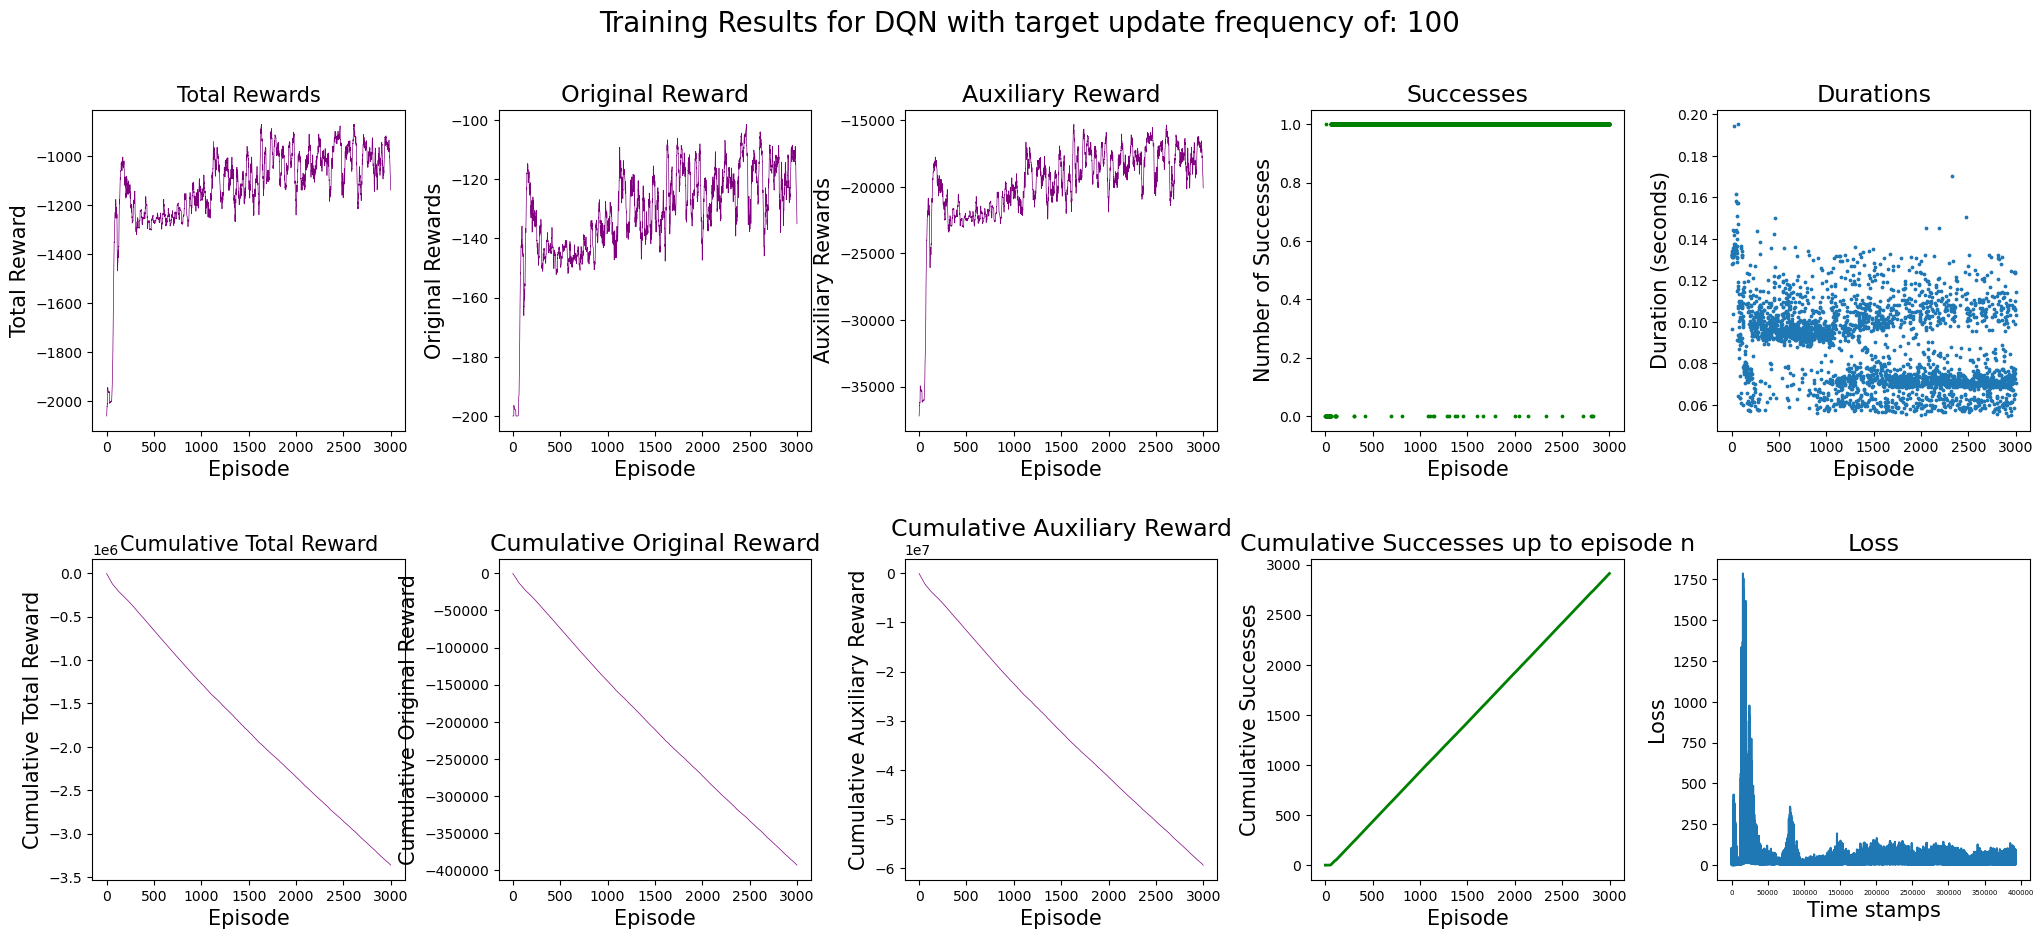

<Figure size 640x480 with 0 Axes>

In [35]:
from DQN import DQNAgent

num_episodes = 3000
reward_function = "complex"
# list_updates = [10000, 5000, 30000, 100000, 1000]
list_updates = [100]

for target_update_frequency in list_updates:
    print("* + "*20)
    print(f"Training DQN for {num_episodes} episodes with reward function: {reward_function} and target update frequency: {target_update_frequency}\n \n")
    env = MountainCarReward1(render_mode=None, C = 100, D = 50, step_penalty=30, aux_factor = 0.05)
    state_size, action_size = env.observation_space.shape[0], env.action_space.n
    agent = DQNAgent(env, state_size, action_size,target_update_frequency = target_update_frequency)
    agent.train(env, agent, num_episodes, reward_function=reward_function)
    agent.save_agent(f"DQN_{num_episodes}_episodes_{reward_function}_targetfrequency_{target_update_frequency}")
    agent.reward_plot(reward_function=reward_function, target_update_frequency=target_update_frequency)


# **3.4** DQN with RND

this is with a reward factor of 100, let's try with small and big ones.

* + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + 
Training DQN for 3000 episodes with reward factor: 500
 

Agent loaded from path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_reward_factor_500/


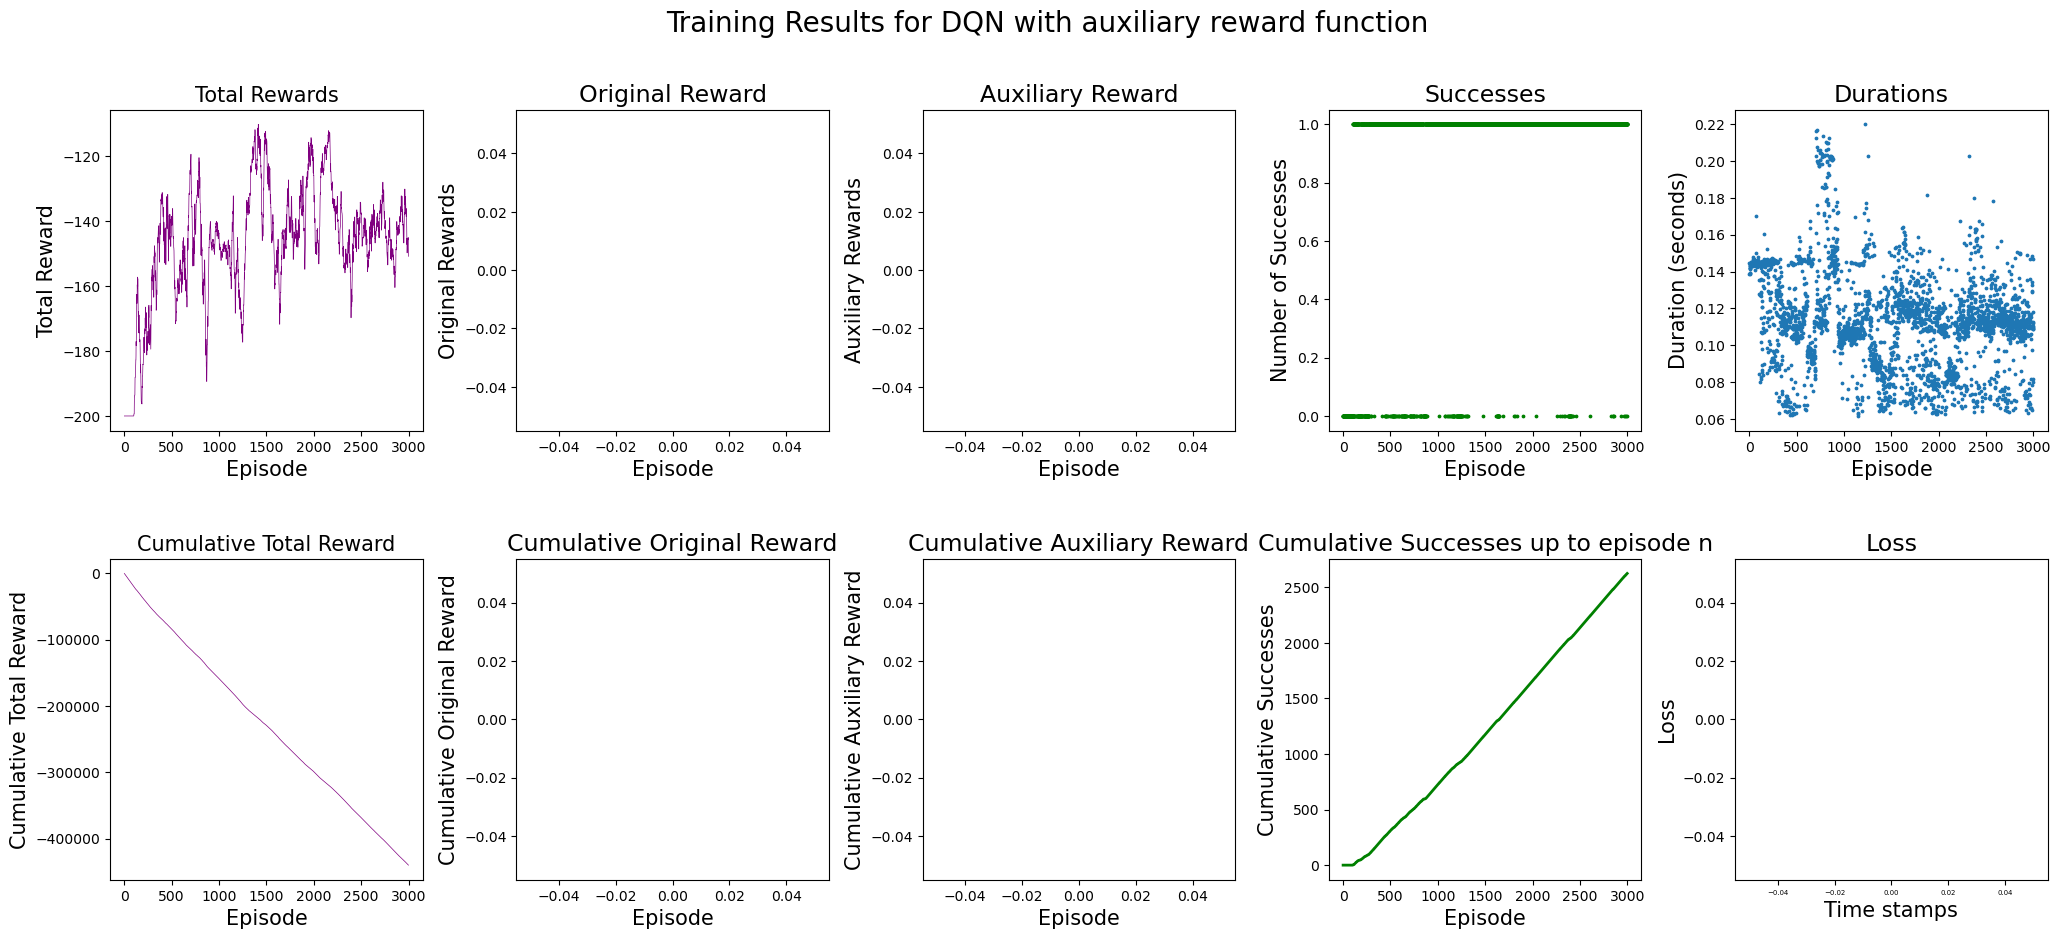

<Figure size 640x480 with 0 Axes>

In [81]:
import gymnasium as gym
from DQN import *

# Define your environment here
env = gym.make("MountainCar-v0")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
num_episodes = 3000

reward_factors = [500]
train = True

for reward_factor in reward_factors:
    print("* + "*20)
    print(f"Training DQN for {num_episodes} episodes with reward factor: {reward_factor}\n \n")
    agent = DQNAgent(
        env=env,
        state_size=state_size,
        action_size=action_size,
        gamma=0.99,
        min_epsilon=0.05,
        max_epsilon=0.9,
        decay_epsilon=0.995,
        replay_buffer_max=10000,
        batch_size=64,
        learning_rate=0.001,
        hidden_layer_sizes=[64, 64],
        target_update_frequency=500,
        reward_factor=reward_factor
    )

    if train:
        rewards = agent.train(env, agent, num_episodes=num_episodes, rnd = True)
        agent.save_agent(f"DQN_{num_episodes}_episodes_reward_factor_{reward_factor}")
    else:
        agent.load_agent(f"DQN_{num_episodes}_episodes_reward_factor_{reward_factor}")
    agent.reward_plot()

In [ ]:
agent.save_agent(f"DQN_{num_episodes}_episodes_reward_factor_{reward_factor}")

# 4 DYNA

In [3]:
from DYNA import *

In [5]:
env = gym.make('MountainCar-v0')
retrain=False
if retrain:
    dyna_agent=DynaAgent(env)
    #train the agent
    dyna_agent.training(3000)
else:
    #load agent
    with open("agents_saved/dyna_agent_final.pkl", 'rb') as f:
        dyna_agent = pickle.load(f)

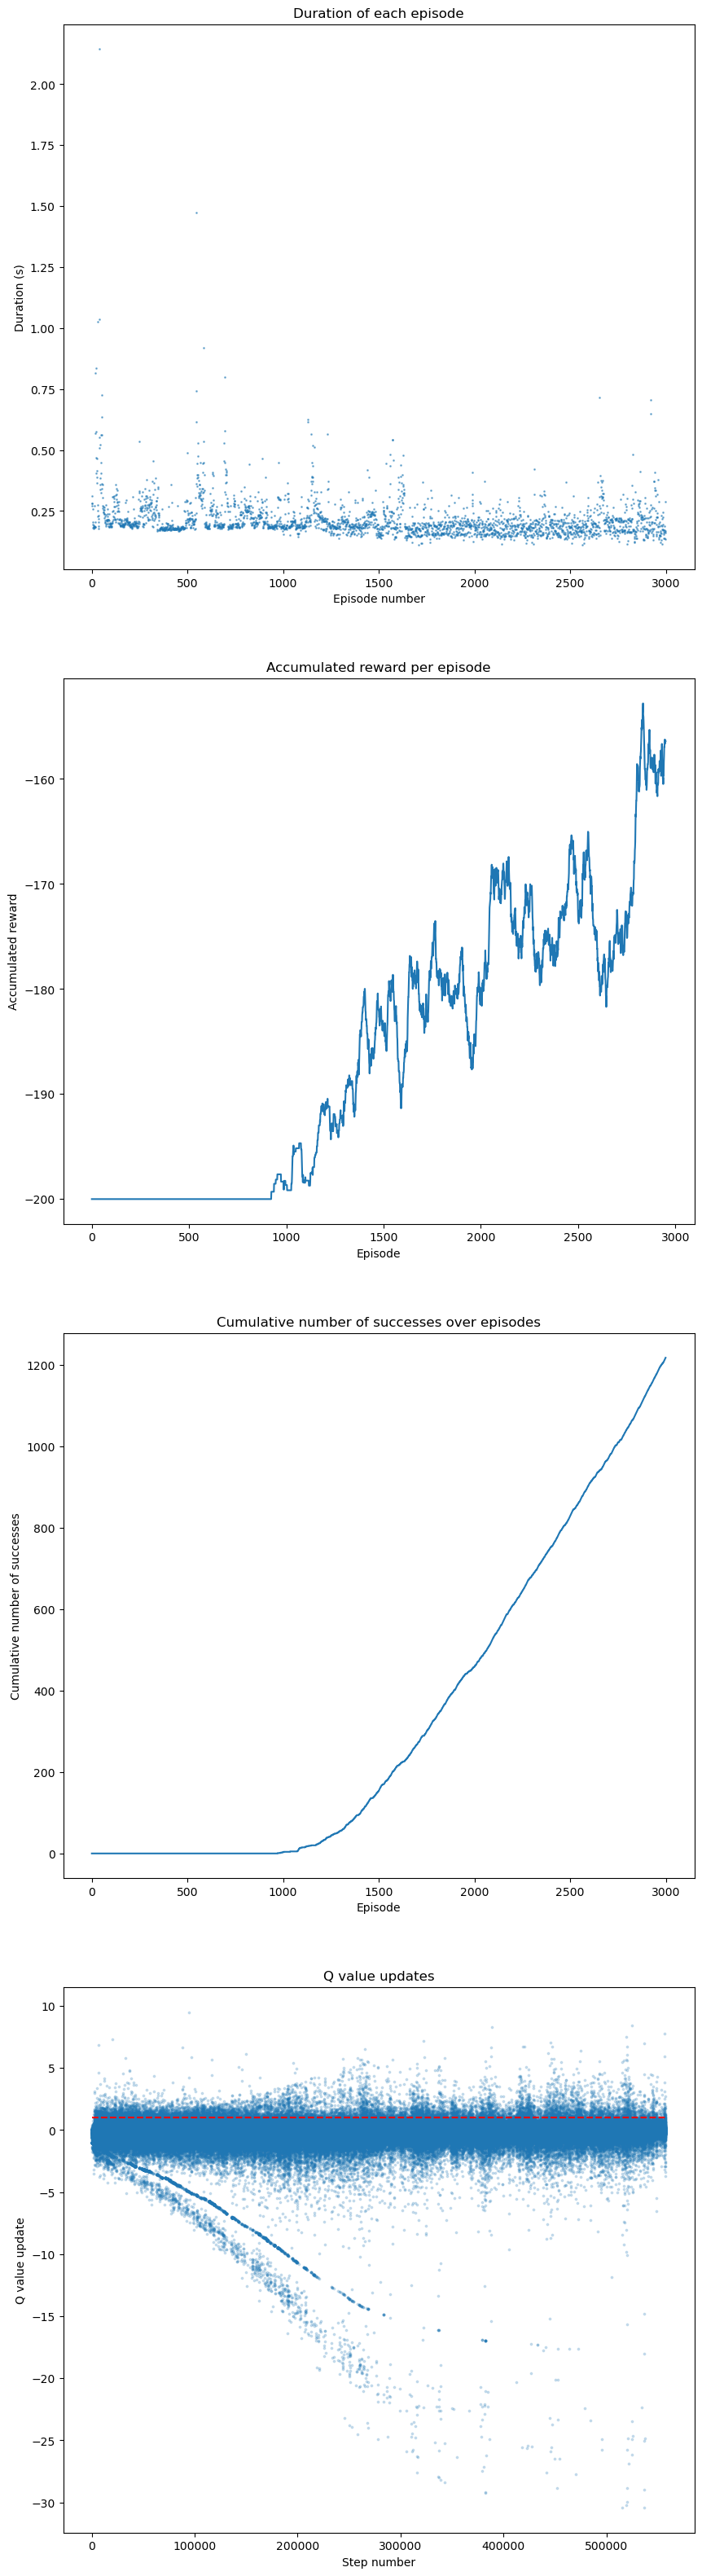

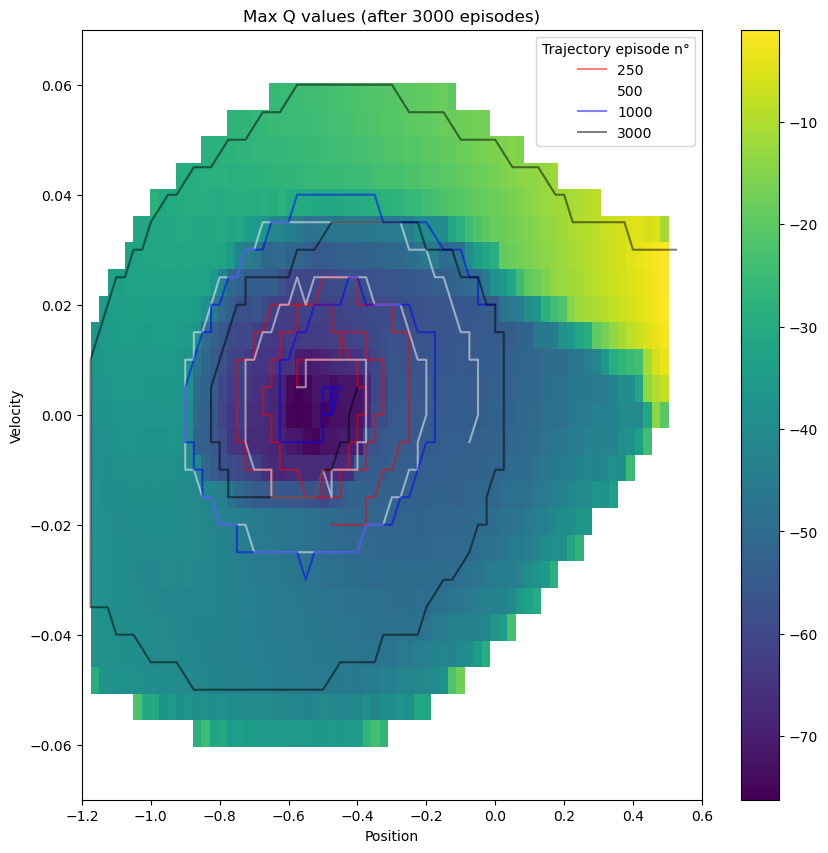

In [4]:
plot_all_on_same_column(dyna_agent)

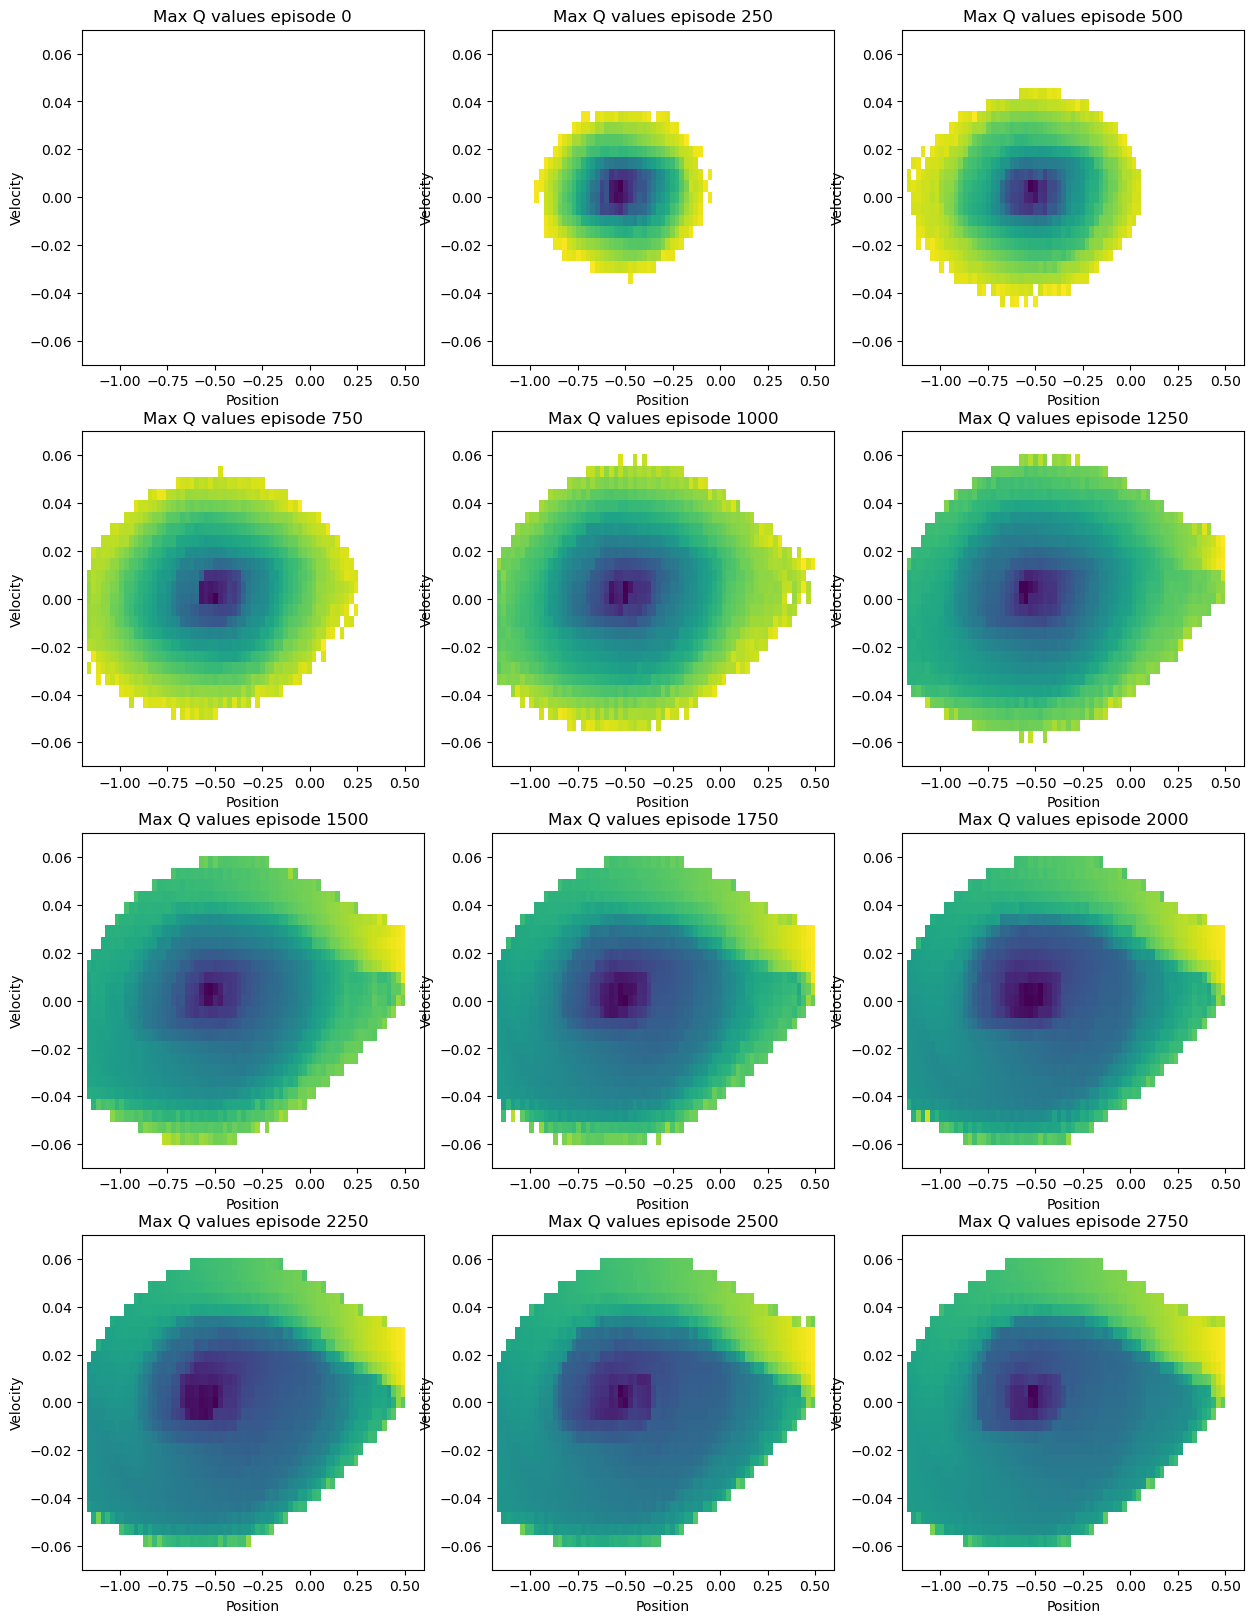

In [5]:
plot_max_q_at_different_episodes(dyna_agent)

The accumulated reward per episode plot is smoothed using a window of size 50

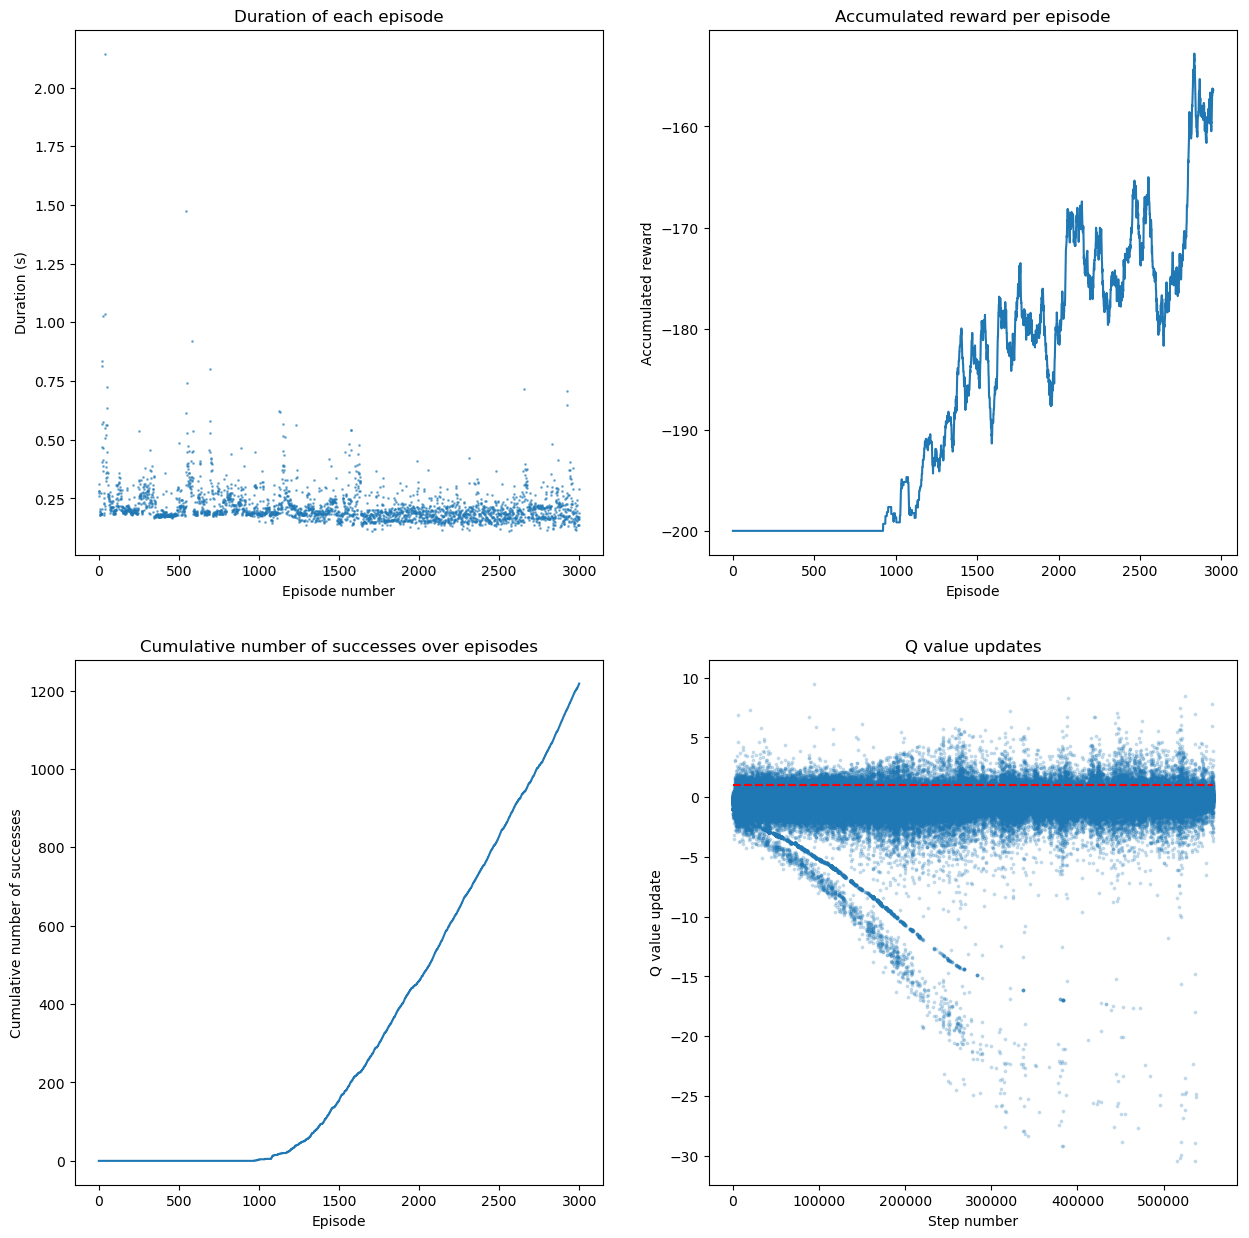

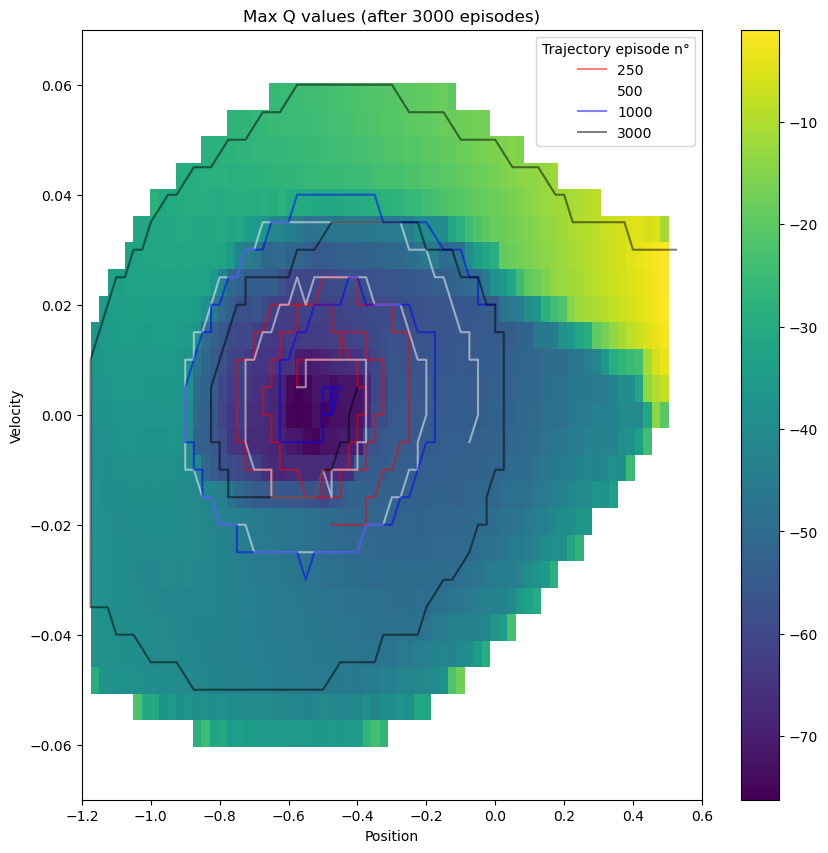

In [6]:
plot_all_on_same_figure(dyna_agent)

In [12]:
sucesss,rewards_dyna=inference_test(dyna_agent,1000,return_rewards=True)

100%|██████████| 1000/1000 [00:17<00:00, 58.10it/s]

Proportion of successful episodes: 79.4 %


In [13]:
np.save("test_rewards_dyna.npy",rewards_dyna)

## 4.1 Influence of discretization

### Small bins

In [6]:
dyna_small=DynaAgent(env,size_bin_x=0.0125,size_bin_y=0.0025)
retrain=False
if retrain:
    dyna_small.training(3000,reset=True,render=False)
else:
    with open("agents_saved/dyna_small.pkl", 'rb') as f:
        dyna_small = pickle.load(f)

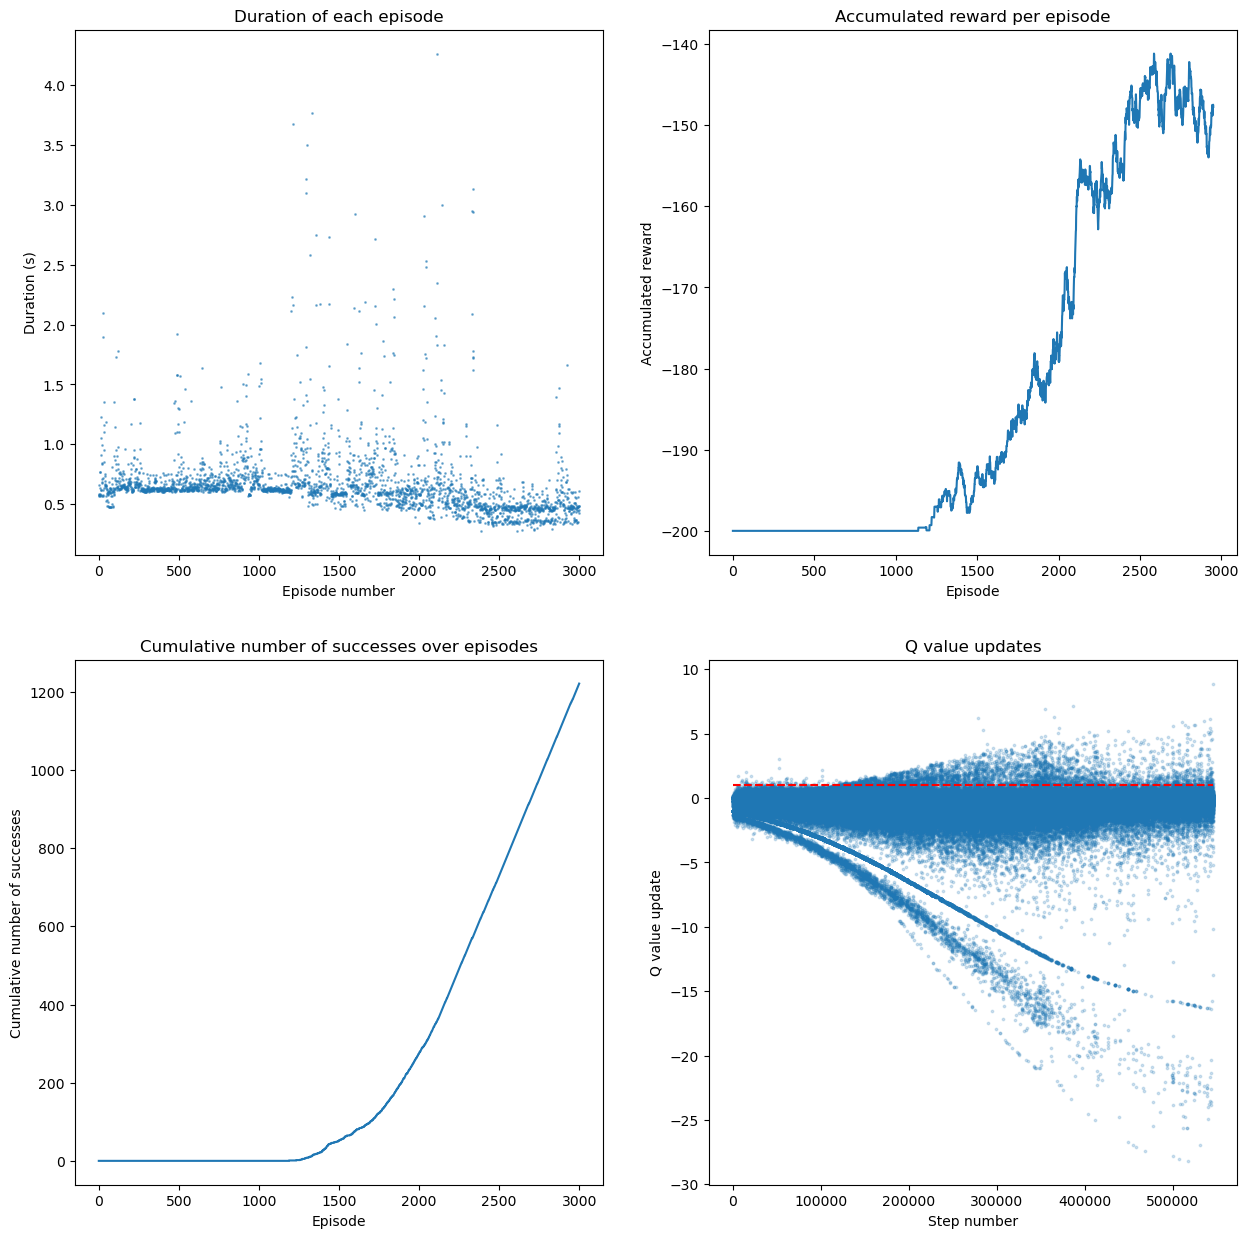

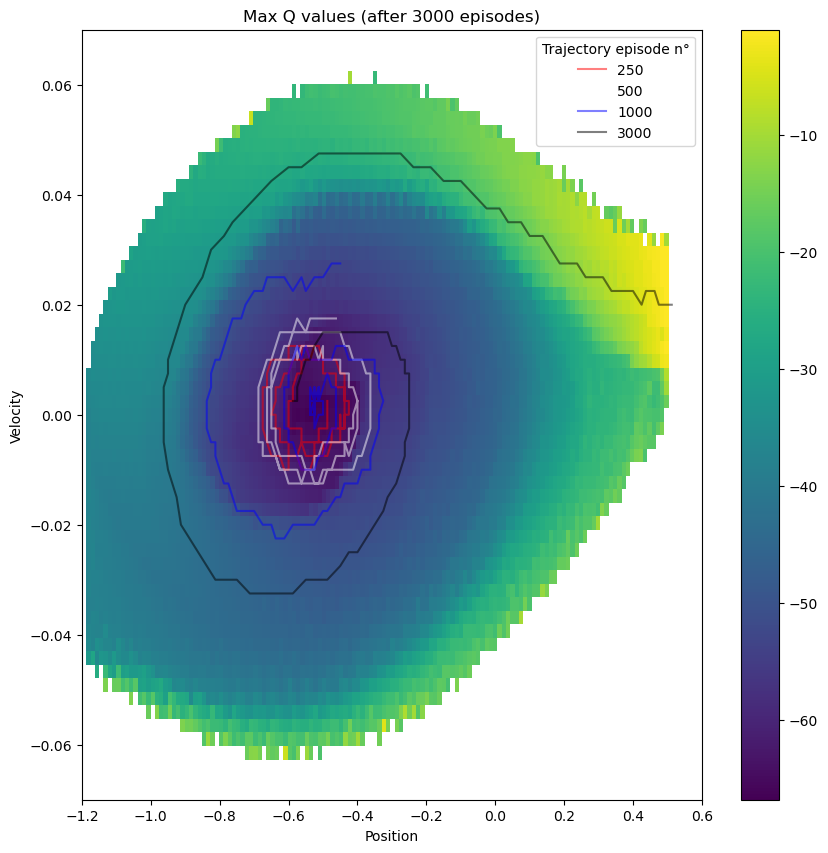

In [15]:
plot_all_on_same_figure(dyna_small)

In [16]:
inference_test(dyna_small,1000)

100%|██████████| 1000/1000 [00:36<00:00, 27.43it/s]

Proportion of successful episodes: 99.3 %


0.993

### Big bins

In [ ]:
dyna_big=DynaAgent(env,size_bin_x=0.05,size_bin_y=0.01)
retrain=True
save=True
if retrain:
    dyna_big.training(3000,reset=True,render=False)
    if save:
        with open("agents_saved/dyna_big.pkl", 'wb') as f:
            pickle.dump(dyna_big, f)
else:
    with open("agents_saved/dyna_big.pkl", 'rb') as f:
        dyna_big = pickle.load(f)

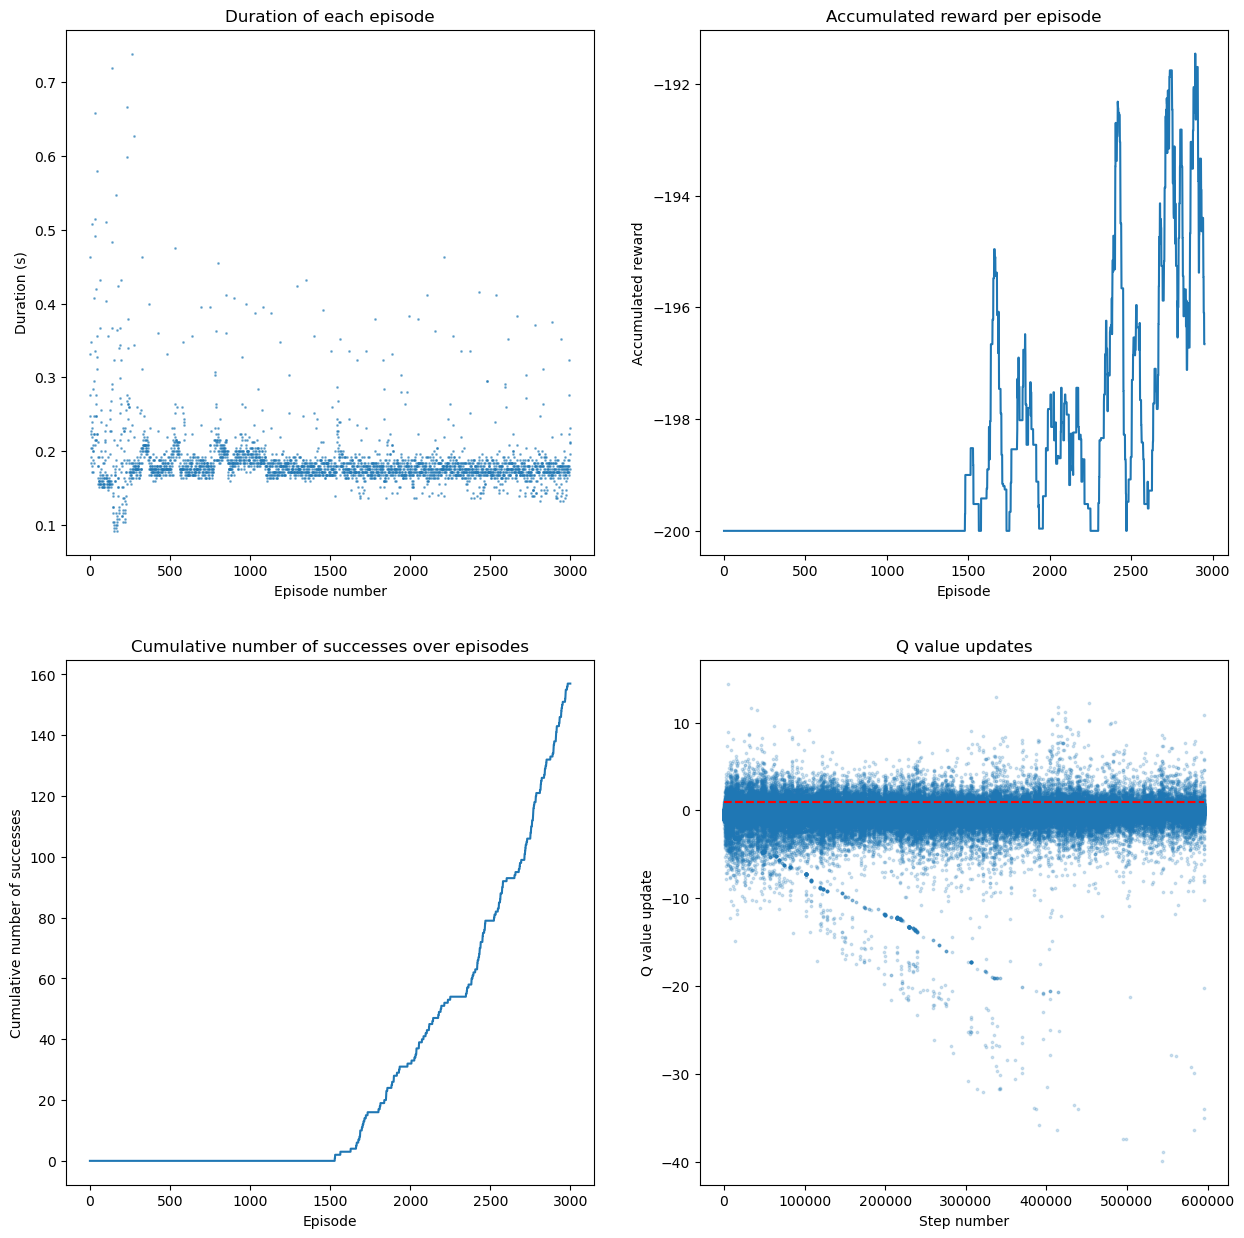

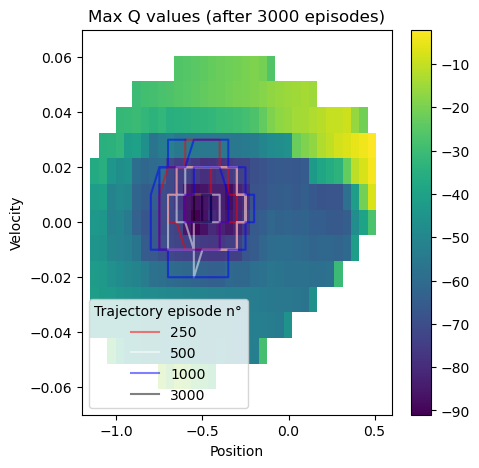

In [29]:
plot_all_on_same_figure(dyna_big)

In [30]:
inference_test(dyna_big,1000)

100%|██████████| 1000/1000 [00:39<00:00, 25.43it/s]

Proportion of successful episodes: 55.50000000000001 %


0.555

# Comparison DQN - DYNA

2991
Agent loaded from path:  c:\Users\Alexi\Documents\EPFL\M12\RL\Project\MountainCartRL/agents_saved/DQN_1000_episodes/
Agent loaded from path:  c:\Users\Alexi\Documents\EPFL\M12\RL\Project\MountainCartRL/agents_saved/DQN_3000_episodes_complex_targetfrequency_100/
Agent loaded from path:  c:\Users\Alexi\Documents\EPFL\M12\RL\Project\MountainCartRL/agents_saved/DQN_3000_episodes_reward_factor_700/


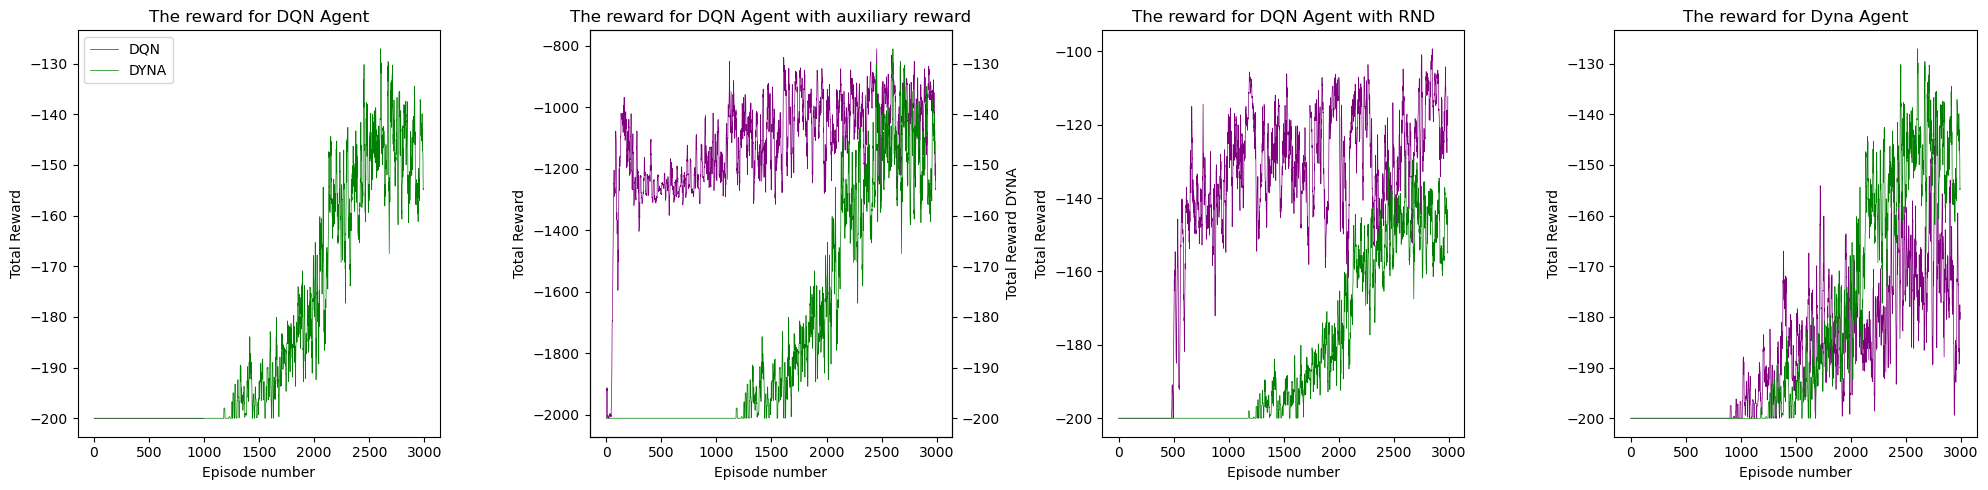

In [35]:
# training rewards plot

from DQN import DQNAgent, DQNnetwork

num_episodes = 1000
sample_seeds = [np.random.randint(0, 100000) for _ in range(1000)]

env = gym.make('MountainCar-v0') #, render_mode = "human"
state_size, action_size = env.observation_space.shape[0], env.action_space.n

rewards_dyna=dyna_agent.cumulative_reward_per_episode
rewards_dyna=np.convolve(rewards_dyna, np.ones(10)/10, mode='valid')
print(len(rewards_dyna))
# DQNAgent
agent = DQNAgent(env, state_size, action_size)
agent.load_agent(f"DQN_1000_episodes")

# DQNAgent with aux reward
env_aux = MountainCarReward1(render_mode=None, C = 100, D = 50, step_penalty=30, aux_factor = 0.05)
agent_aux = DQNAgent(env_aux, state_size, action_size)
agent_aux.load_agent(f"DQN_3000_episodes_complex_targetfrequency_100")

# DQNRNDAgent
agent_rnd = DQNAgent(env, state_size, action_size)
agent_rnd.load_agent("DQN_3000_episodes_reward_factor_700")

# plot the reward of agent
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
rewards = np.load("agents_saved/DQN_1000_episodes/rewards.npy")
rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
axs[0].plot(rewards, color="purple", linewidth=0.5,label="DQN")
axs[0].plot(rewards_dyna, color="green", linewidth=0.5,label="DYNA")
axs[0].legend()
axs[0].set_title("The reward for DQN Agent")
axs[0].set_ylabel("Total Reward")
axs[0].set_xlabel("Episode number")

rewards = np.load("agents_saved/DQN_3000_episodes_complex_targetfrequency_100/rewards.npy")
rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
axs[1].plot(rewards, color="purple", linewidth=0.5)
#plot reward dyna on with another y-axis
ys2=axs[1].twinx()
ys2.plot(rewards_dyna, color="green", linewidth=0.5,label="DYNA")
ys2.set_ylabel("Total Reward DYNA")
axs[1].set_title("The reward for DQN Agent with auxiliary reward")
axs[1].set_ylabel("Total Reward")
axs[1].set_xlabel("Episode number")

rewards = np.load("agents_saved/DQN_3000_episodes_reward_factor_700/rewards.npy")
rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
axs[2].plot(rewards, color="purple", linewidth=0.5)
axs[2].plot(rewards_dyna, color="green", linewidth=0.5,label="DYNA")
axs[2].set_title("The reward for DQN Agent with RND")
axs[2].set_ylabel("Total Reward")
axs[2].set_xlabel("Episode number")

# load dyna
rewards = np.load("dyna_cumulative_reward_per_episode.npy")
rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
axs[3].plot(rewards, color="purple", linewidth=0.5)
axs[3].plot(rewards_dyna, color="green", linewidth=0.5,label="DYNA")
axs[3].set_title("The reward for Dyna Agent")
axs[3].set_ylabel("Total Reward")
axs[3].set_xlabel("Episode number")

plt.tight_layout()


In [64]:
# comparing the testing performance on 1000 new episodes, each one initialized with a randomly sampled seed as before: 
# Set ε = 0 and run each of the trained agents on testing environments. 
# Make sure you are comparing the agents on the same set of seeds. Plot their performance and comment.

from DQN import DQNAgent, DQNnetwork

num_episodes = 1000
sample_seeds = [np.random.randint(0, 100000) for _ in range(1000)]

env = gym.make('MountainCar-v0') #, render_mode = "human"
state_size, action_size = env.observation_space.shape[0], env.action_space.n

# # DQNAgent
# agent = DQNAgent(env, state_size, action_size, min_epsilon=0, max_epsilon=0) # Set ε = 0 to test
# agent.train(env, agent, num_episodes,reward_function="-1")
# agent.save_agent(f"DQN_{num_episodes}_episodes_TEST")

# # DQNAgent with aux reward
# env_aux = MountainCarReward1(render_mode=None, C = 100, D = 50, step_penalty=30, aux_factor = 0.05)
# agent_aux = DQNAgent(env_aux, state_size, action_size, min_epsilon=0, max_epsilon=0) # Set ε = 0 to test
# agent_aux.train(env_aux, agent_aux, num_episodes,reward_function="complex")
# agent_aux.save_agent(f"DQN_{num_episodes}_episodes_aux_TEST")

# DQNRNDAgent
agent_rnd = DQNAgent(env, state_size, action_size, min_epsilon=0, max_epsilon=0) # Set ε = 0 to test
agent_rnd.train(env, agent_rnd, num_episodes,rnd=True)
agent_rnd.save_agent(f"DQN_{num_episodes}_episodes_rnd_TEST")



  0%|          | 0/1000 [00:00<?, ?it/s]/Users/silviaromanato/anaconda3/envs/arm64env/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1000/1000 [03:05<00:00,  5.39it/s]

Directory created:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes_rnd_TEST/
Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes_rnd_TEST/


1000 1000
1000 1000 991


Text(0.5, 0, 'Episode number')

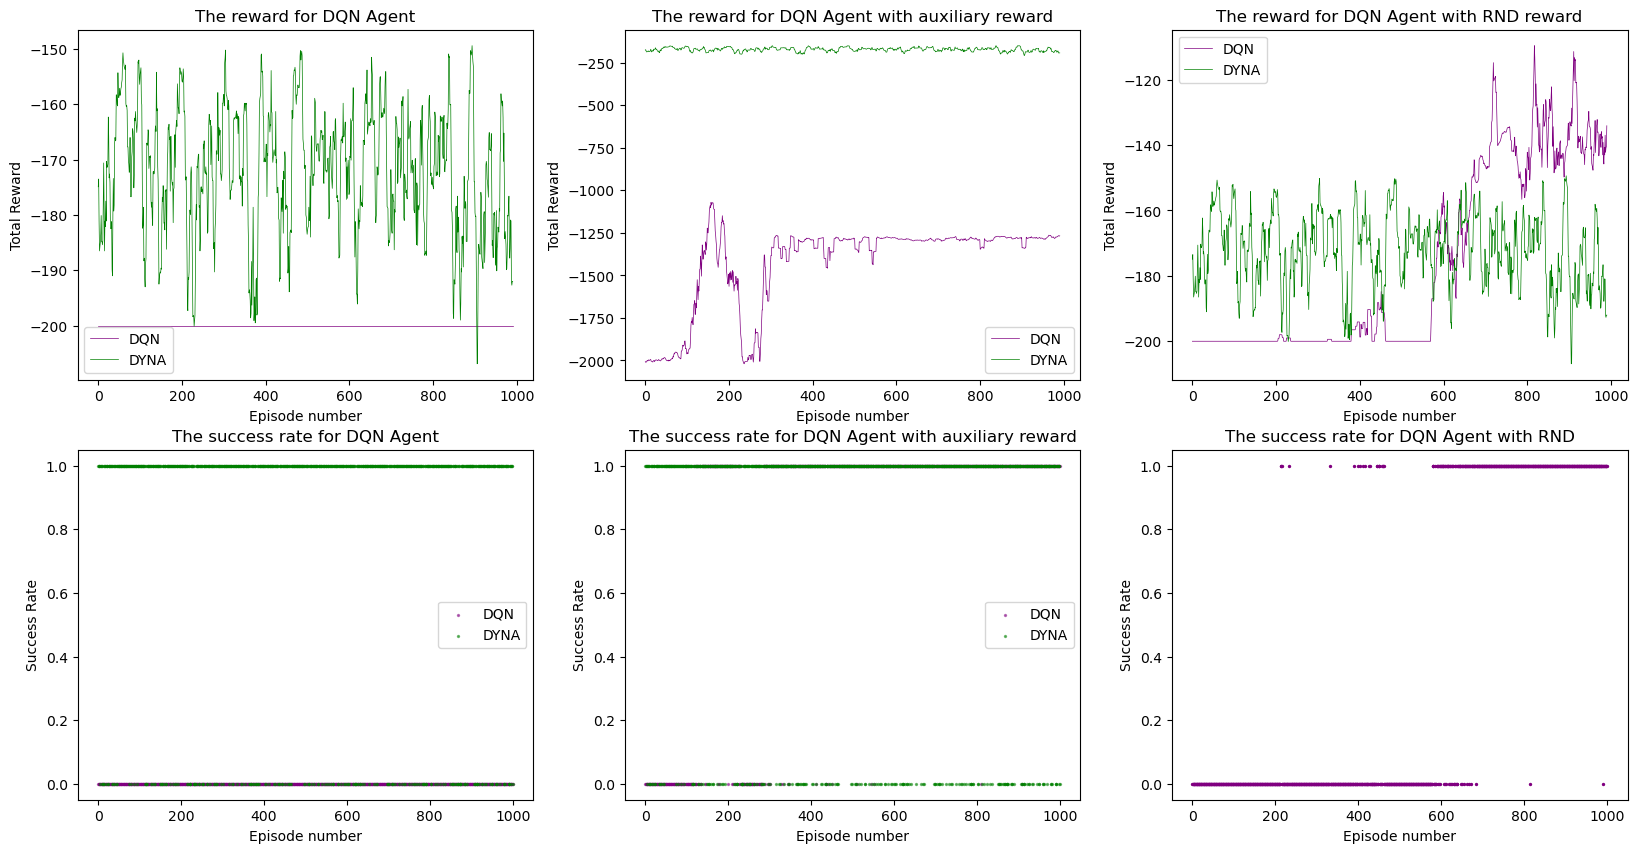

In [21]:
# plot the reward of agent
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

#DYNA_TEST
reward_dyna = np.load("test_rewards_dyna.npy")
success_dyna=(reward_dyna>=-200).astype(int)
print(len(reward_dyna), len(success_dyna))
reward_dyna = np.convolve(reward_dyna, np.ones(10)/10, mode='valid')



# DQN TEST
rewards = np.load("agents_saved/DQN_1000_episodes_TEST/rewards.npy")
rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
axs[0, 0].plot(rewards, color="purple", linewidth=0.5,label="DQN")
axs[0,0].plot(reward_dyna, color="green", linewidth=0.5,label="DYNA")
axs[0, 0].legend()
axs[0, 0].set_title("The reward for DQN Agent")
axs[0, 0].set_ylabel("Total Reward")
axs[0, 0].set_xlabel("Episode number")

successes = np.load("agents_saved/DQN_1000_episodes_TEST/dones.npy")
y = np.linspace(0, 1000, 1000)
print(len(y), len(successes), len(rewards))

axs[1, 0].scatter(y, successes, s = 2,alpha=0.5, color='purple',label="DQN")
axs[1,0].scatter(y, success_dyna, color="green", s=2, alpha=0.5, label="DYNA")
axs[1, 0].legend()
axs[1, 0].set_title("The success rate for DQN Agent")
axs[1, 0].set_ylabel("Success Rate")
axs[1, 0].set_xlabel("Episode number")

# DQN with aux reward TEST
rewards = np.load("agents_saved/DQN_1000_episodes_aux_TEST/rewards.npy")
rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
axs[0, 1].plot(rewards, color="purple", linewidth=0.5,label="DQN")
axs[0,1].plot(reward_dyna, color="green", linewidth=0.5,label="DYNA")
axs[0, 1].legend()
axs[0, 1].set_title("The reward for DQN Agent with auxiliary reward")
axs[0, 1].set_ylabel("Total Reward")
axs[0, 1].set_xlabel("Episode number")

successes = np.load("agents_saved/DQN_1000_episodes_aux_TEST/dones.npy")
axs[1, 1].scatter(y, successes, s = 2, alpha=0.5, color='purple',label="DQN")
axs[1,1].scatter(y,success_dyna, s=2,alpha=0.5, color="green",label="DYNA")
axs[1, 1].legend()
axs[1, 1].set_title("The success rate for DQN Agent with auxiliary reward")
axs[1, 1].set_ylabel("Success Rate")
axs[1, 1].set_xlabel("Episode number")

# DQN with RND TEST
rewards = np.load("agents_saved/DQN_1000_episodes_rnd_TEST/rewards.npy")
rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
axs[0, 2].plot(rewards, color="purple", linewidth=0.5,label="DQN")
axs[0,2].plot(reward_dyna, color="green", linewidth=0.5,label="DYNA")
axs[0, 2].legend()
axs[0, 2].set_title("The reward for DQN Agent with RND reward")
axs[0, 2].set_ylabel("Total Reward")
axs[0, 2].set_xlabel("Episode number")

successes = np.load("agents_saved/DQN_1000_episodes_rnd_TEST/dones.npy")
axs[1, 2].scatter(y, successes, s = 2, color='purple')
axs[1, 2].set_title("The success rate for DQN Agent with RND")
axs[1, 2].set_ylabel("Success Rate")
axs[1, 2].set_xlabel("Episode number")